In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import with_statement
import heapq
import os
import sys
import time
import numpy as np
import time
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
from numba import jit
from osgeo import gdal, osr

In [2]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

"""
The pathfinder algorithm.
"""
def seek(
    origins,
    targets=None,
    weights=None,
    path_handling='link',
    debug=False,
    film=False,
):
    """
    Find the shortest paths between *any* origin and *each* target.

    Pathfinder is a modified version of Dijkstra's algorithm
    (https://en.wikipedia.org/wiki/Dijkstra's_algorithm) for finding
    the shortest distance between two points in a graph. It differs in
    a few important ways:

    * It finds the shortest distance between a target point and the
        nearest of a set of origin points. This is then repeated for
        each target point.
    * It assumes a gridded topology. In other words, it knows that
        each node only
        touches its neighbors to the north, south, east, west,
        northeast, northwest, southeast, and southwest.

    Like Dijkstra's, Pathfinder assumes that all weights are 0 or greater.
    Negative weights are set to zero.  All input arrays (origins,
    targets, and weights) need to have the same number of rows and columns.

    @param origins, targets: 2D numpy array of ints
        Any non-zero values are the locations of origin and target points,
        respectively. Note that both may be modified. Target points may
        be removed, once paths to them are found and origins may be
        augmented (see path_handling param below).
        If targets is not supplied, no targets are assumed and a targets
        array of all zeros is created. This is useful for calculating minimum
        distances from a set of origins to all points of the grid.
    @param weights: 2D numpy array of floats
        The cost of visiting a grid square, zero or greater.
        For favorable (easy to traverse) grid locations, this is low.
        For unfavorable grid locations, this is high.
        If not supplied, a weights array of all ones is used. This is
        useful for calculating as-the-crow-flies distance.
    @param path_handling: string
        One of {'link', 'assimilate', 'none', 'l', 'a', 'n'}.
        Determines how to handle paths between target and origins,
        once they are found.

        * 'link' or 'l'  adds a target to the origins once it is found,
            as well as the path connecting them. This mode
            is good for growing a network by connecting nodes, as we do here
            when planning or estimating an electrical grid.
        * 'assimilate' or 'a' adds a target to the origins once it is found,
            but does not add the path connecting them. This mode
            is good for growing a network by adding nodes that
            have no physical connection between them, as in planning an
            ad-hoc wireless network.
        * 'none' or 'n' doesn't add a target to the to the origins
            once it is found. This mode is good for finding a path
            from a backbone or trunk to many leaf nodes,
            as in planning fiber backhaul routing.

    @param debug: boolean
        If True, provide text updates on the algorithm's progress.
    @param film: boolean
        If True, periodically save snapshots of the algorithm's progress.

    @retun results: dict
        'paths': 2D numpy array of ints
            1 where paths have been found, and 0 everywhere else.
        'distance: 2D numpy array of floats
            The length of the shortest path (the sum of the weights of grid
            cells traversed) from the nearest origin point to every point
            on the grid. Origin points have a distance of zero, and it
            goes up from there the further away you get.
        'rendering': 2D numpy array of floats
            An image representing the final state of the algorithm, including
            paths found and distances calculated.
    """
    if weights is None:
        weights = np.ones(origins.shape)
    if targets is None:
        targets = np.zeros(origins.shape, dtype=np.int8)
    assert targets.shape == origins.shape
    assert targets.shape == weights.shape
    path_handling = path_handling.lower()
    assert path_handling in ['none', 'n', 'assimilate', 'a', 'link', 'l']
    n_rows, n_cols = origins.shape
    if path_handling[0] == 'n':
        path_handling = 0
    elif path_handling[0] == 'a':
        path_handling = 1
    elif path_handling[0] == 'l':
        path_handling = 2

    iteration = 0
    not_visited = 9999999999.

    if film:
        frame_rate = int(1e4)
        frame_counter = 100000
        frame_dirname = 'frames'
        try:
            os.mkdir(frame_dirname)
        except Exception:
            # NBD
            pass

        cwd = os.getcwd()
        try:
            os.chdir(frame_dirname)
            for filename in os.listdir('.'):
                os.remove(filename)
        except Exception:
            print('Frame deletion failed')
        finally:
            os.chdir(cwd)

    rendering = 1. / (2. * weights)
    rendering = np.minimum(rendering, 1.)
    target_locations = np.where(targets)
    n_targets = target_locations[0].size
    n_targets_remaining = n_targets
    n_targets_remaining_update = n_targets
    for i_target, row in enumerate(target_locations[0]):
        col = target_locations[1][i_target]
        wid = 8
        rendering[
            row - wid:
            row + wid + 1,
            col - wid:
            col + wid + 1] = .5

    # The distance array shows the shortest weighted distance from
    # each point in the grid to the nearest origin point.
    distance = np.ones((n_rows, n_cols)) * not_visited
    origin_locations = np.where(origins != 0)
    distance[origin_locations] = 0.

    # The paths array shows each of the paths that are discovered
    # from targets to their nearest origin point.
    paths = np.zeros((n_rows, n_cols), dtype=np.int8)

    # The halo is the set of points under evaluation. They surround
    # the origin points and expand outward, forming a growing halo
    # around the set of origins that eventually enevlops targets.
    # It is implemented using a heap queue, so that the halo point
    # nearest to an origin is always the next one that gets evaluated.
    halo = []
    for i, origin_row in enumerate(origin_locations[0]):
        origin_col = origin_locations[1][i]
        heapq.heappush(halo, (0., (origin_row, origin_col)))

    # The temporary array for tracking locations to add to the halo.
    # This gets overwritten with each iteration.
    new_locs = np.zeros((int(1e6), 3))
    n_new_locs = 0

    while len(halo) > 0:
        iteration += 1
        if debug:
            if (n_targets_remaining > n_targets_remaining_update or
                    iteration % 1e4 == 0.):
                n_targets_remaining = n_targets_remaining_update
                print('\r {num} targets of {total} reached, {rem} remaining, {halo_len} to try '
                      .format(
                          num=n_targets - n_targets_remaining,
                          total=n_targets,
                          rem=n_targets_remaining,
                          halo_len=len(halo),
                      ), end='')
                sys.stdout.flush()
        if film:
            if iteration % frame_rate == 0:
                frame_counter = render(
                    distance,
                    frame_counter,
                    frame_dirname,
                    not_visited,
                    rendering,
                )

        # Reinitialize locations to add.
        new_locs[:n_new_locs, :] = 0.
        n_new_locs = 0

        # Retrieve and check the location with shortest distance.
        (distance_here, (row_here, col_here)) = heapq.heappop(halo)
        n_new_locs, n_targets_remaining_update = nb_loop(
            col_here,
            distance,
            distance_here,
            n_cols,
            n_new_locs,
            n_rows,
            n_targets_remaining,
            new_locs,
            not_visited,
            origins,
            path_handling,
            paths,
            row_here,
            targets,
            weights,
        )
        for i_loc in range(n_new_locs):
            loc = (int(new_locs[i_loc, 1]), int(new_locs[i_loc, 2]))
            heapq.heappush(halo, (new_locs[i_loc, 0], loc))

    if debug:
        print('\r                                                 ', end='')
        sys.stdout.flush()
        print('')
    # Add the newfound paths to the visualization.
    rendering = 1. / (1. + distance / 10.)
    rendering[np.where(origins)] = 1.
    rendering[np.where(paths)] = .8
    results = {'paths': paths, 'distance': distance, 'rendering': rendering}
    return results

def render(
    distance,
    frame_counter,
    frame_dirname,
    not_visited,
    rendering,
):
    """
    Turn the progress of the algorithm into a pretty picture.
    """
    progress = rendering.copy()
    visited_locs = np.where(distance < not_visited)
    progress[visited_locs] = 1. / (1. + distance[visited_locs] / 10.)
    filename = 'pathfinder_frame_' + str(frame_counter) + '.png'
    cmap = 'inferno'
    dpi = 1200
    plt.figure(33374)
    plt.clf()
    plt.imshow(
        progress,
        origin='upper',
        interpolation='nearest',
        cmap=plt.get_cmap(cmap),
        vmax=1.,
        vmin=0.,
    )
    filename_full = os.path.join(frame_dirname, filename)
    plt.savefig(filename_full, dpi=dpi)
    frame_counter += 1
    return frame_counter


@jit(nopython=True)
def nb_trace_back(
    distance,
    n_new_locs,
    new_locs,
    not_visited,
    origins,
    path_handling,
    paths,
    target,
    weights,
):
    """
    Connect each found electrified target to the grid through
    the shortest available path.
    """
    # Handle the case where you find more than one target.
    path = []
    distance_remaining = distance[target]
    current_location = target
    while distance_remaining > 0.:
        path.append(current_location)
        (row_here, col_here) = current_location
        # Check each of the neighbors for the lowest distance to grid.
        neighbors = [
            ((row_here - 1, col_here), 1.),
            ((row_here + 1, col_here), 1.),
            ((row_here, col_here + 1), 1.),
            ((row_here, col_here - 1), 1.),
            ((row_here - 1, col_here - 1), 2.**.5),
            ((row_here + 1, col_here - 1), 2.**.5),
            ((row_here - 1, col_here + 1), 2.**.5),
            ((row_here + 1, col_here + 1), 2.**.5),
        ]
        lowest_distance = not_visited
        # It's confusing, but keep in mind that
        # distance[neighbor] is the distance from the neighbor position
        # to the grid, while neighbor_distance is
        # the distance *through*
        # the neighbor position to the grid. It is distance[neighbor]
        # plus the distance to the neighbor from the current position.
        for (neighbor, scale) in neighbors:
            if neighbor not in path:
                distance_from_neighbor = scale * weights[current_location]
                neighbor_distance = (distance[neighbor] +
                                     distance_from_neighbor)
                if neighbor_distance < lowest_distance:
                    lowest_distance = neighbor_distance
                    best_neighbor = neighbor

        # This will fail if caught in a local minimum.
        if distance_remaining < distance[best_neighbor]:
            distance_remaining = 0.
            continue

        distance_remaining = distance[best_neighbor]
        current_location = best_neighbor

    # Add this new path.
    for i_loc, loc in enumerate(path):
        paths[loc] = 1
        # If paths are to be linked, include the entire paths as origins and
        # add them to new_locs. If targets are to be assimilated, just add
        # the target (the first point on the path) to origins and new_locs.
        if path_handling == 2 or (
                path_handling == 1 and i_loc == 0):
            origins[loc] = 1
            distance[loc] = 0.
            new_locs[n_new_locs, 0] = 0.
            new_locs[n_new_locs, 1] = loc[0]
            new_locs[n_new_locs, 2] = loc[1]
            n_new_locs += 1

    return n_new_locs


@jit(nopython=True)
def nb_loop(
    col_here,
    distance,
    distance_here,
    n_cols,
    n_new_locs,
    n_rows,
    n_targets_remaining,
    new_locs,
    not_visited,
    origins,
    path_handling,
    paths,
    row_here,
    targets,
    weights,
):
    """
    This is the meat of the computation.
    Pull the computationally expensive operations from seek()
    out into their own function that can be pre-compiled using numba.
    """
    # Calculate the distance for each of the 8 neighbors.
    neighbors = [
        ((row_here - 1, col_here), 1.),
        ((row_here + 1, col_here), 1.),
        ((row_here, col_here + 1), 1.),
        ((row_here, col_here - 1), 1.),
        ((row_here - 1, col_here - 1), 2.**.5),
        ((row_here + 1, col_here - 1), 2.**.5),
        ((row_here - 1, col_here + 1), 2.**.5),
        ((row_here + 1, col_here + 1), 2.**.5),
    ]

    for (neighbor, scale) in neighbors:
        weight = scale * weights[neighbor]
        neighbor_distance = distance_here + weight

        if distance[neighbor] == not_visited:
            if targets[neighbor]:
                n_new_locs = nb_trace_back(
                    distance,
                    n_new_locs,
                    new_locs,
                    not_visited,
                    origins,
                    path_handling,
                    paths,
                    neighbor,
                    weights,
                )
                targets[neighbor] = 0
                n_targets_remaining -= 1
        if neighbor_distance < distance[neighbor]:
            distance[neighbor] = neighbor_distance
            if (neighbor[0] > 0 and
                    neighbor[0] < n_rows - 1 and
                    neighbor[1] > 0 and
                    neighbor[1] < n_cols - 1):
                new_locs[n_new_locs, 0] = distance[neighbor]
                new_locs[n_new_locs, 1] = neighbor[0]
                new_locs[n_new_locs, 2] = neighbor[1]
                n_new_locs += 1
    return n_new_locs, n_targets_remaining


In [9]:
def update_weights_with_roads(weights, roads, weight):
    assert weights.shape == roads.shape
    for i in range(roads.shape[0]):
        for j in range(roads.shape[1]):
            if roads[i][j] == 1:
                weights[i][j] = min(weights[i][j], weight)
    return weights
def update_weights_with_grid(weights, grid):
    # assuming all HV grid values > 0 and resulting weights should be ~0
    assert weights.shape == grid.shape
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i][j] > 0:
                weights[i][j] = min(weights[i][j], 0.000000001)
    return weights
def validate(true, pred):
    """
        Takes ground truth and predicted values as input, returns:
        precision: a low score indicates overestimation of positives
        accuracy: heavly influenced by the number of true negatives
        iou: excludes true negatives, above 50% is satisfactory in object detection
    """
    from sklearn.metrics import confusion_matrix
   
    tn, fp, fn, tp = confusion_matrix(true.flatten(), pred.flatten()).ravel()
    precision = 100*(tp/(tp+fp))
    accuracy = 100*(tp+tn)/(tp+tn+fp+fn)
    iou = 100*(tp)/(tp+fn+fp)
    print(tn, fp, fn, tp)
    return precision, accuracy, iou,

In [4]:
def create_raster_from_array(original, output, array):
    origin = gdal.Open(original)
    band = origin.GetRasterBand(1)

    geotransform = origin.GetGeoTransform()
    wkt = origin.GetProjection()

    # Create GeoTiff file
    driver = gdal.GetDriverByName("GTiff")
   

    dst_ds = driver.Create(output,
                           band.XSize,
                           band.YSize,
                           1,
                           gdal.GDT_Int16)


    # Writing output raster
    dst_ds.GetRasterBand(1).WriteArray(array)
    #setting nodata value
    dst_ds.GetRasterBand(1).SetNoDataValue(0)
    #setting extension of output raster
    # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
    dst_ds.SetGeoTransform(geotransform)
    # setting spatial reference of output raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection(srs.ExportToWkt())
    #Close output raster dataset

    ds = None
    dst_ds = None

In [5]:
### Initiates all data files, needs to be ran for every iteration of seek()
def predict_grid(
    bv_file,
    bv_threshold=1,
    existing_grid=None,
    validation_grid=None,
    road_weighting=None, 
    road_dir=None,
    film=False,
    input_origin=None
):
    brightness_values = Image.open(bv_file)
    brightness_values = np.array(brightness_values)
    targets = (lambda x: x>bv_threshold)(brightness_values)*1
    
    origin = np.zeros(targets.shape)
    if input_origin:
        origin[input_origin[0]][input_origin[1]] = 1
    else:
        for i in range(int(targets.shape[0]/2), targets.shape[0]): # Origin is set to the first target point found, somewhere close to center
            for j in range(int(targets.shape[1]/2), targets.shape[1]):
                if targets[i][j]:
                    origin[i][j] = 1
                    break

    weights = np.ones(targets.shape)
    if road_dir:
        roads_list = [path for path in os.listdir(road_dir) if path[-3:] == 'tif']
        for road_type in roads_list:
            r = Image.open(road_dir+road_type)
            r = np.array(r)
            r = (lambda x:x==1)(r)*1
            update_weights_with_roads(weights, r, road_weighting[road_type[:-4]])

    if existing_grid:
        grid = Image.open(existing_grid)
        grid = np.array(grid)
        update_weights_with_grid(weights, grid)
    
    results = seek(
        origin,
        targets=targets,
        weights=weights,
        film=film
    )
    
    if validation_grid:
        validation = Image.open(validation_grid)
        validation = np.array(validation)
        validation = (lambda x: x>0)(validation)*1
        precision, accuracy, iou = validate(validation, results['paths'])
        return results, precision, accuracy, iou
    
    return results

1.812468 0.30550949999999943


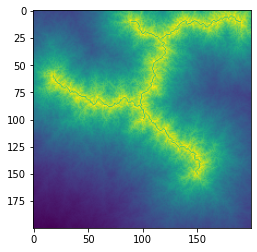

In [6]:
# This precompiles numba code
import time

test_origins = np.zeros((200,200))
test_origins[100,100]  = 1
test_targets = np.zeros((200,200))
test_targets[150,150], test_targets[10, 190], test_targets[60, 18], test_targets[10, 90], test_targets[30,120] = 1, 1, 1, 1, 1

weights = [[random.random() for j in range(200)] for i in range(200)]
weights = np.array(weights)

tic = time.perf_counter()
out = seek(test_origins, targets=test_targets, weights=weights)
tok = time.perf_counter()

tic1 = time.perf_counter()
out1 = seek(test_origins, targets=test_targets, weights=weights)
tok1 = time.perf_counter()

print(tok-tic, tok1-tic1)
%matplotlib inline
plt.imshow(out['rendering'])

In [8]:
road_weights = {
    'primary': 0.1,
    'secondary': 0.25,
    'tertiary': 0.4,
    'service': 0.8,
    'unclassified': 0.6
}
countries = ['uganda']#, 'namibia']
datasets = ['bv_ww_062020']
thresholds = [0.60]
origins = [(940, 740)]#, (1360, 1295)]
for dataset in datasets:
    for country, origin in zip(countries, origins):
        road_dir = f'datasets/{country}/roads/'
        existing_grid = f'datasets/{country}/hv_lines.tif'
        validation_grid = f'datasets/{country}/grid.tif'    
        bv_path = f'datasets/{country}/{dataset}.tif'
        output = f'results/{country}/040_pred_paths.tif'
        for bv_threshold in thresholds:
            results, precision, accuracy, iou = predict_grid(
                bv_path,
                bv_threshold=bv_threshold,
                road_weighting=road_weights,
                existing_grid=existing_grid,
                validation_grid=validation_grid,
                road_dir=road_dir,
                input_origin=origin
            )
            print(precision, accuracy, iou)
            #create_raster_from_array(bv_path, output, results['paths'] )

1735824 10687 27686 13897
56.528636511552236 97.85397188290996 26.586952362731967


datasets/uganda/bv_ww_062020.tif results/uganda/best_paths.tif
datasets/namibia/bv_ww_062020.tif results/namibia/best_paths.tif


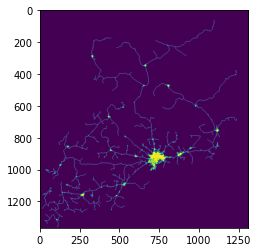

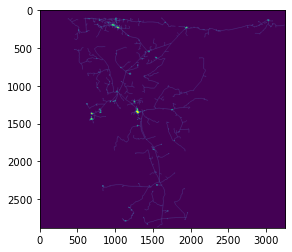

In [41]:
%matplotlib inline
originals = ['datasets/uganda/bv_ww_062020.tif', 'datasets/namibia/bv_ww_062020.tif']
outputs = ['results/uganda/best_paths.tif', 'results/namibia/best_paths.tif']
for original, output, result in zip(originals, outputs, results):
    print(original, output)
    plt.figure()
    plt.imshow(result['paths'])
    create_raster_from_array(original, output, result['paths'])

In [46]:
road_weights = {
    'primary': 0.1,
    'secondary': 0.25,
    'tertiary': 0.4,
    'service': 0.8,
    'unclassified': 0.6
}
countries = ['uganda'] #, 'namibia']
origins = [(940, 740)] #, (1360, 1295)]
datasets = ['bv_ww_062020', 'bv_ave_ww_2020']
thresholds = [0.40, 0.60, 1.00]

for dataset in datasets:
    for country, origin in zip(countries, origins):
        road_dir = f'datasets/{country}/roads/'
        existing_grid = f'datasets/{country}/hv_lines.tif'
        validation_grid = f'datasets/{country}/grid.tif'    
        bv_path = f'datasets/{country}/{dataset}.tif'
        for bv_threshold in thresholds:
            results, precision, accuracy, iou = predict_grid(
                bv_path,
                bv_threshold=bv_threshold,
                road_weighting=road_weights,
                existing_grid=existing_grid,
                validation_grid=validation_grid,
                road_dir=road_dir,
                input_origin=origin
            )
            result_line = f'\n{dataset},{bv_threshold},{round(precision,2)},{round(accuracy,2)},{round(iou,2)}'
            file = open(f'results/{country}/results.txt', 'a')
            file.write(result_line)
            file.close()
            
            valid_plot = np.array(Image.open(f'datasets/{country}/grid.tif'))
            valid_plot = (lambda x: x>0)(valid_plot)*1
            plt.figure(figsize=(20,12))
            plt.title("Predicted Grid vs. Actual Grid")
            plt.subplot(121)
            plt.imshow(results['paths'])
            plt.subplot(122)
            plt.imshow(valid_plot)
            plt.savefig(f"results/{country}/{dataset}_predicted_grid_vs_actual_grid{str(bv_threshold).replace('.', '_')}.png")
            plt.close()
            
# tn, fp, fn, tp

1723784 22727 23783 17800
1735824 10687 27686 13897
1740253 6258 30722 10861
1698407 48104 20037 21546
1723033 23478 24892 16691
1732918 13593 28479 13104


In [47]:
100*13897/(13897+27686)

33.4199071736046

In [21]:
distinguished = {
    'primary': 0.1,
    'secondary': 0.25,
    'tertiary': 0.4,
    'service': 0.8,
    'unclassified': 0.6
}
roads = {
    'primary': 0.3,
    'secondary': 0.3,
    'tertiary': 0.3,
    'service': 0.3,
    'unclassified': 0.3
}
default = {
    'primary': 1,
    'secondary': 1,
    'tertiary': 1,
    'service': 1,
    'unclassified': 1
}
country = 'uganda'
dataset = 'bv_ww_062020'
bv_threshold =0.60

weights = [default, roads, distinguished]
for config in weights:
    road_dir = f'datasets/{country}/roads/'
    existing_grid = f'datasets/{country}/hv_lines.tif'
    validation_grid = f'datasets/{country}/grid.tif'    
    bv_path = f'datasets/{country}/{dataset}.tif'
    results, precision, accuracy, iou = predict_grid(
        bv_path,
        bv_threshold=bv_threshold,
        road_weighting=config,
        existing_grid=existing_grid,
        validation_grid=validation_grid,
        road_dir=road_dir,
    )
    print(precision, accuracy, iou)

1722457 24054 29455 12128
33.519429550605274 97.00748394659341 18.477383183265538
1722757 23754 27107 14476
37.8655506147005 97.15557459507163 22.15589941380841
1724511 22000 24518 17065
43.68360424932804 97.3984589177079 26.83893493543872


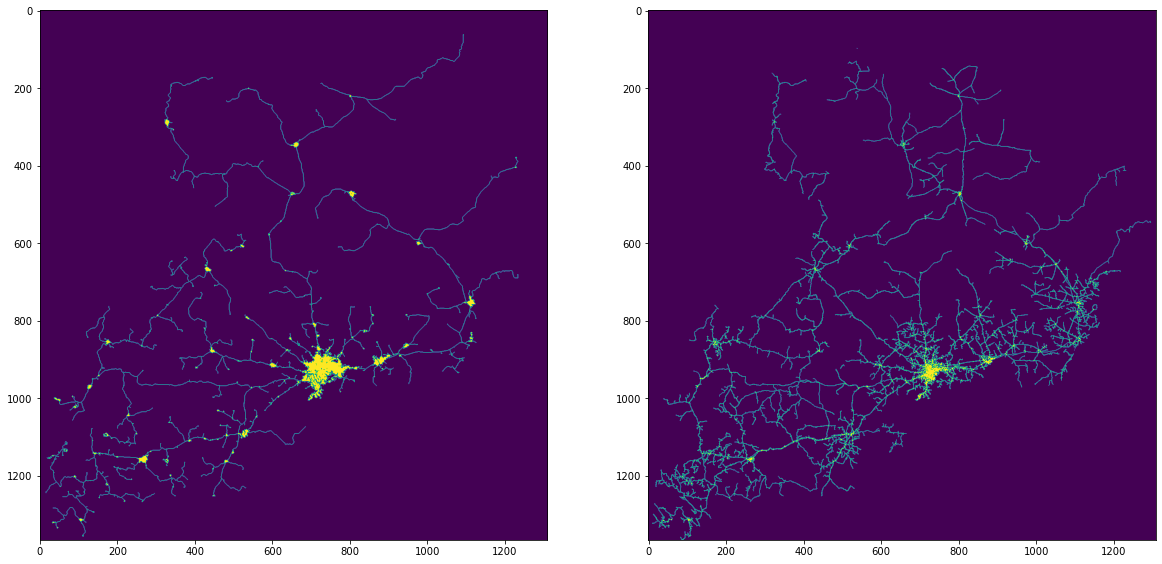

In [96]:
plt.figure(figsize=(20,12))
plt.title("Predicted Grid vs. Actual Grid")
plt.subplot(121)
plt.imshow(uganda_results['paths'])
plt.subplot(122)
plt.imshow(uganda_grid)
plt.savefig("results/uganda/predicted_grid_vs_actual_grid.png")

Number of targets (left image):  56169 
Number of targets (right image):  189292


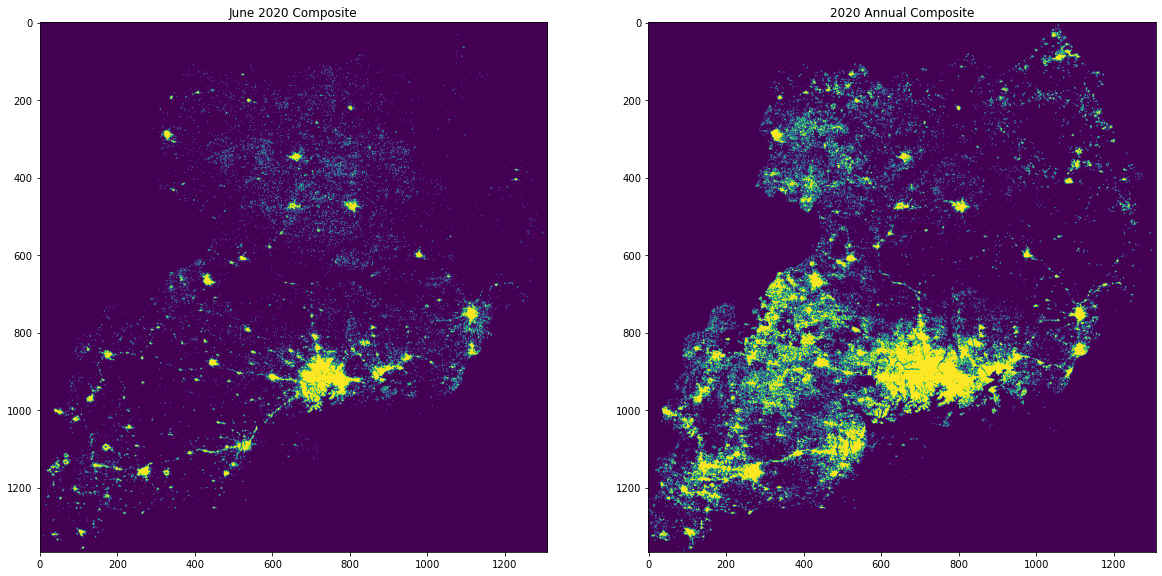

In [12]:
%matplotlib inline
threshold = 0.3

monthly_in = np.array(Image.open('datasets/uganda/bv_ww_062020.tif'))
annual_in = np.array(Image.open('datasets/uganda/bv_ave_ww_2020.tif'))

monthly = (lambda x: x>threshold)(monthly_in)*1
annual = (lambda x: x>threshold)(annual_in)*1
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.title('June 2020 Composite')
plt.imshow(monthly)
plt.subplot(122)
plt.title('2020 Annual Composite')
plt.imshow(annual)
plt.savefig(f"results/monthly_vs_annual_bv_threshold{threshold}.png")
print('Number of targets (left image): ', monthly.sum(), '\nNumber of targets (right image): ', annual.sum())

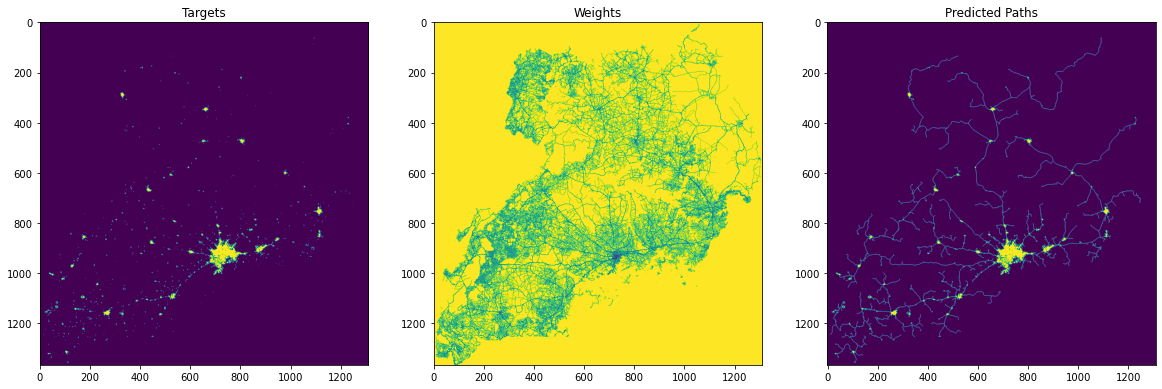

In [11]:
%matplotlib inline
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.title("Targets")
plt.imshow(targets)
plt.subplot(132)
plt.title("Weights")
plt.imshow(weights)
plt.subplot(133)
plt.title("Predicted Paths")
plt.imshow(results['paths'])
plt.savefig('results/uganda/targets_weights_paths.png')

1786


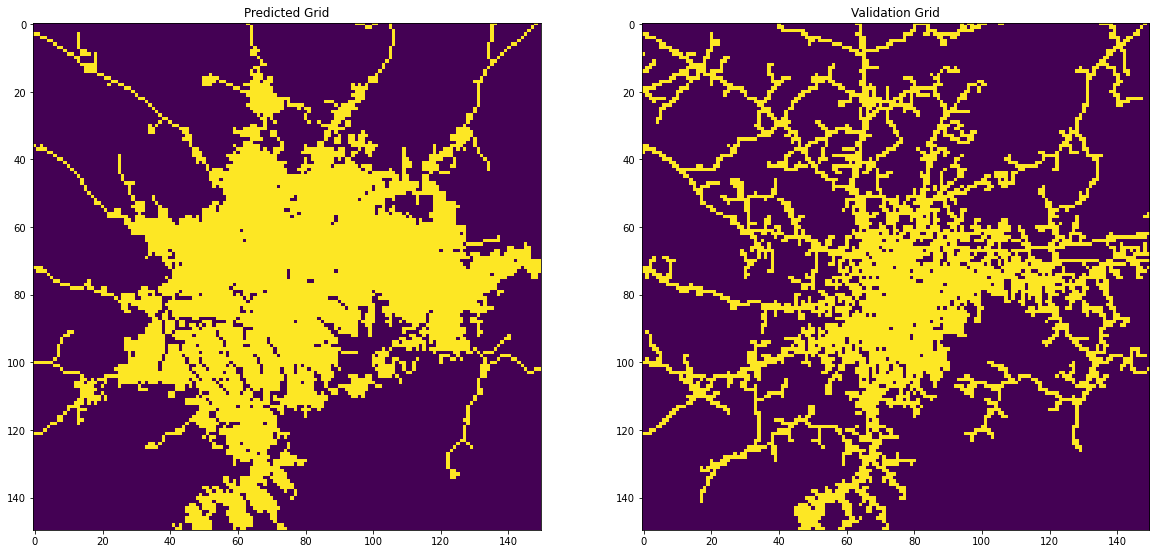

In [11]:
validation = Image.open('datasets/uganda/grid.tif')
validation = np.array(validation)
validation = (lambda x: x>0)(validation)*1
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.title("Predicted Grid")
plt.imshow(results['paths'][850:1000, 650:800])
plt.subplot(122)
plt.title("Validation Grid")
plt.imshow(validation[850:1000, 650:800])
# plt.savefig("results/grid_saturation.png")
print((results['paths'][850:1000, 650:800]-validation[850:1000, 650:800]).sum())

In [55]:
validation = np.array(Image.open('datasets/uganda/05deg_val.tif')).astype(int)
prediction = np.array(Image.open('datasets/uganda/05deg_pred_040bvt.tif')).astype(int)

validation = (lambda x: x>0)(validation)*1
prediction = (lambda x: x>0)(prediction)*1

prec, acc, iou = validate(validation, prediction)
print(prec, acc, iou)

9321 743 857 1619
68.54360711261643 87.24082934609251 50.29512270891581


In [56]:
validation = np.array(Image.open('datasets/namibia/05deg_val.tif')).astype(int)
prediction = np.array(Image.open('datasets/namibia/05deg_pred_040bvt.tif')).astype(int)

validation = (lambda x: x>0)(validation)*1
prediction = (lambda x: x>0)(prediction)*1

prec, acc, iou = validate(validation, prediction)
print(round(prec,2), round(acc,2), round(iou, 2))

58142 1555 3053 2561
62.22 92.94 35.72


In [57]:
four = np.average([43.92,97.4,27.68])
six = np.average([56.53,97.85,26.59])
one = np.average([63.44,97.93,22.7])
print(four, six, one)

56.333333333333336 60.32333333333333 61.35666666666666
